# Pobranie tekstu oraz jego strukturyzacja do formatu JSON

Poniższy notatnik prezentuje kod źródłowy skryptów napisanych w języku Python, które posłużyły do pobrania ze strony https://wolnelektury.pl tekstu dramatu autorstwa Stanisłwa Wyspiańskiego, pt.: _Wesele_. Tekst został następnie ustrukturyzowany w postaci słownika zawierającego dane dotyczące poszczególnych aktów i scen dramatu, wraz z podziałem dialogów na kwestie wypowiadane przez poszczególnych ich uczestników. Słownik został następnie przekonwertowany do formatu JSON oraz zapisany w postaci pliku `wesele-data.json`.

In [1]:
from bs4 import BeautifulSoup
import re
import requests
import json

In [2]:
def roman_to_int(s):
    '''Function transforming Roman numerals into Arabic'''
    rom_val = {'I': 1, 'V': 5, 'X': 10, 'L': 50, 'C': 100, 'D': 500, 'M': 1000}
    int_val = 0
    for i in range(len(s)):
        if i > 0 and rom_val[s[i]] > rom_val[s[i - 1]]:
            int_val += rom_val[s[i]] - 2 * rom_val[s[i - 1]]
        else:
            int_val += rom_val[s[i]]
    return int_val

In [3]:
def make_soup(url, headers):
    '''Function that returns an object BeautifulSoup'''
    req = requests.get(wesele_url, headers=headers)
    return BeautifulSoup(req.content, "html5lib")

In [4]:
wesele_url = 'https://wolnelektury.pl/katalog/lektura/wesele.html#anchor-idm140526473078944'
headers = {"User-Agent" : "Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build/MRA58N) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Mobile Safari/537.36"}
soup = make_soup(wesele_url, headers)

In [5]:
author = soup.find("span", {"class" : "author"}).get_text(strip=True)
title = soup.find("span", {"class" : "title"}).get_text(strip=True)
subtitle = soup.find("span", {"class" : "subtitle"}).get_text(strip=True)
persons_list = []
for div in soup.find_all("div", {"class" : "person-list"}):
    persons = [person.get_text(strip=True) for person in div.find_all("li")]
    persons_list.extend(persons)

In [6]:
main_text = soup.find("h3", text=re.compile("DEKORACJA")).find_next_siblings()
text = []
# dodanie do listy text wszystkich tagów, które nie są linkami (przypisami, numerami stron, etc.)
for tag in main_text:
    if tag.name != "a":
        [a.extract() for a in tag("a")]
        [span.extract() for span in tag("span")]
        text.append(tag)
        continue

In [7]:
decoration = ""
for p in text:
    p_text = p.get_text(strip=True)
    if p_text.startswith("AKT I"):
        break
    decoration += "\n" + p_text

In [8]:
persons_list = [] 
for div in soup.find_all("div", {"class" : "person-list"}):
    persons = [person.get_text(strip=True) for person in div.find_all("li")]
    persons_list.extend(persons)

In [9]:
start_acts = []
# pętla tworząca listę indeksów, od których rozpoczyna się każdy akt
for index, tag in enumerate(text):
    if tag.name == "h2":
#         tag_text = tag.get_text(strip=True)
#         act_number = roman_to_int(tag_text[4:])
        start_acts.append(index)
        continue
    if tag.get("id") == "footnotes":
        last_index = index
        continue

In [10]:
acts_indexes = []
start_stop_tuple = ()
# pętla tworząca listę krotek zawierających indeks początkowy i indeks końcowy aktów
for i, start_index in enumerate(start_acts):
    if i < len(start_acts) - 1:
        start_stop_tuple += (start_index, start_acts[i + 1])
        acts_indexes.append(start_stop_tuple)
        start_stop_tuple = ()
        continue
    else:
        start_stop_tuple += (start_index, last_index)
        acts_indexes.append(start_stop_tuple)
        del start_stop_tuple

In [11]:
acts_list_of_dicts = []
acts = [text[start:stop] for (start, stop) in acts_indexes]

for act in acts:

    act_dict = {
        "Akt" : None,
        "Didaskalia" : None,
        "Sceny" : []
    }

    # Flaga sprawdzająca czy didaskalia przyporządkowane są do aktu czy do sceny
    inside_scene = False
    # lista indeksów początkowych scen
    start_scenes = []

    for i, element in enumerate(act):

        if element.name == "h2":
            act_number = roman_to_int(element.get_text(strip=True)[4:])
            act_dict["Akt"] = act_number
            continue
        elif inside_scene == False and element.name == "div" and element["class"][0] == "didaskalia":
            act_dict["Didaskalia"] = re.sub(re.compile(r"\s,\s"), ", ", element.get_text(strip=True, separator=" "))
            continue
        elif element.name == "h3":
            inside_scene = True
            start_scenes.append(i)  
            
            
    for i, start_index in enumerate(start_scenes):
        if i < len(start_scenes) - 1:
            act_dict["Sceny"].append(act[start_index:start_scenes[i+1]])
            continue
        else:
            act_dict["Sceny"].append(act[start_index:])
    
    acts_list_of_dicts.append(act_dict)

In [13]:
print(acts_list_of_dicts)
print(len(acts_list_of_dicts))

[{'Akt': 1, 'Didaskalia': None, 'Sceny': [[<h3>SCENA I</h3>, <div class="didaskalia">
<em class="person">Czepiec</em>, <em class="person">Dziennikarz</em>
</div>, <h4>CZEPIEC</h4>, <div class="kwestia"><div class="stanza">
<p class="verse">Cóz tam, panie, w polityce?</p>
<p class="verse">Chińcyki trzymają się mocno!?</p>
</div></div>, <h4>DZIENNIKARZ</h4>, <div class="kwestia"><div class="stanza">
<p class="verse">A, mój miły gospodarzu,</p>
<p class="verse">mam przez cały dzień dosyć Chińczyków.</p>
</div></div>, <h4>CZEPIEC</h4>, <div class="kwestia"><div class="stanza">
<p class="verse">Pan polityk!</p>
</div></div>, <h4>DZIENNIKARZ</h4>, <div class="kwestia"><div class="stanza">
<p class="verse" style="padding-left: 12em">Otóż właśnie polityków</p>
<p class="verse">mam dość, po uszy, dzień cały.</p>
</div></div>, <h4>CZEPIEC</h4>, <div class="kwestia"><div class="stanza">
<p class="verse">Kiedy to ciekawe sprawy.</p>
</div></div>, <h4>DZIENNIKARZ</h4>, <div class="kwestia"><div cla

In [55]:
structured_text = []

for act_index, act_content in enumerate(acts_list_of_dicts):
    # Skopiowanie struktury poprzedniej listy do nowej w celu nie ingerowania w iterowaną listę
    act_dict = {
        "Akt" : act_content["Akt"],
        "Didaskalia" : act_content["Didaskalia"]
    }  
    structured_text.append(act_dict)
    for scene_content in act_content["Sceny"]:
        scene_dict = {
            "Scena" : None,
            "Didaskalia" : [],
            "Dialog" : []
        }
        for element in scene_content:
            
            if element.name == "h3":
                scene_number = roman_to_int(element.get_text(strip=True)[6:])
                scene_dict["Scena"] = scene_number

            elif element.name == "div" and element["class"][0] == "didaskalia":
                scene_dict["Didaskalia"].append(re.sub(re.compile(r"\s,\s"), ", ", element.get_text(strip=True, separator=" ")))

            elif element.name == "h4":
                person = element.get_text(strip=True)
                inside_dailog = True

            elif element.name == "div" and element["class"][0] == "kwestia":
                stanza = "\n".join([p.get_text(strip=True, separator = " ") for p in element.find("div", {"class" : "stanza"}).find_all("p", {"class" : "verse"})])

                dialog_dict = {
                    "Osoba" : person,
                    "Zwrotka" : stanza
                }

                scene_dict["Dialog"].append(dialog_dict)
    structured_text[act_index]["Sceny"].append(scene_dict)
    
    
    

KeyError: 'Sceny'

In [26]:
structured_text = []

for act_element in range(len(acts_list_of_dicts)):
    
    # Skopiowanie struktury poprzedniej listy do nowej w celu nie ingerowania w iterowaną listę
    act_dict = {
        "Akt" : acts_list_of_dicts[act_element]["Akt"],
        "Didaskalia" : acts_list_of_dicts[act_element]["Didaskalia"],
        "Sceny" : []
    }
    structured_text.append(act_dict)
    
    for scene_index, scene in enumerate(acts_list_of_dicts[act_element]):
        print(scene_index)
        
#         for scene in acts_list_of_dicts[act_element]["Sceny"]:

#             scene_dict = {
#                 "Scena" : None,
#                 "Didaskalia" : [],
#                 "Dialog" : []
#             }

#             for element in scene:
            
#                 if element.name == "h3":
#                     scene_number = roman_to_int(element.get_text(strip=True)[6:])
#                     scene_dict["Scena"] = scene_number

#                 elif element.name == "div" and element["class"][0] == "didaskalia":
#                     scene_dict["Didaskalia"].append(re.sub(re.compile(r"\s,\s"), ", ", element.get_text(strip=True, separator=" ")))

#                 elif element.name == "h4":
#                     person = element.get_text(strip=True)
#                     inside_dailog = True

#                 elif element.name == "div" and element["class"][0] == "kwestia":
#                     stanza = "\n".join([p.get_text(strip=True, separator = " ") for p in element.find("div", {"class" : "stanza"}).find_all("p", {"class" : "verse"})])

#                     dialog_dict = {
#                         "Osoba" : person,
#                         "Zwrotka" : stanza
#                     }

#                     scene_dict["Dialog"].append(dialog_dict)
#             structured_text[act_element]["Sceny"].append(scene_dict)
           

0
1
2
0
1
2
0
1
2


In [24]:
print(len(structured_text))

3


In [13]:
full_text = {
    "Autor" : author,
    "Tytuł" : title,
    "Podtytuł" : subtitle,
    "Dekoracja" : decoration,
    "Akty" : structured_text
}

In [14]:
with open("data/wesele-data.json", "w") as json_data:
    json.dump(full_text, json_data, ensure_ascii=False)

# Utworzenie grafu
Poniższy fragment tworzy strukturę grafu za pomocą biblioteki NetworkX, eksportuje go do pliku `wesele_network.gexf`, następnie oblicza miary centralności poszczególnych węzłów i eksportuje je do pliku `centrality-measures.json`

In [15]:
import networkx as nx
from itertools import combinations

In [16]:
G = nx.Graph()

for index, act in enumerate(full_text['Akty']):
    for scene in act['Sceny']:
        nodes = set()
        for dialog in scene['Dialog']:
            if  "," in dialog["Osoba"] or "WSZYSCY" in dialog["Osoba"]:
                continue
            nodes.add(dialog["Osoba"])
        edges = list(combinations(nodes, 2))
        
        for edge in edges:
            if G.has_edge(edge[0], edge[1]):
                G[edge[0]][edge[1]]["weight"] += 1
            else:
                G.add_edge(edge[0], edge[1], weight=1)
# Show all edges
print(G.edges(data=True))

[('CZEPIEC', 'DZIENNIKARZ', {'weight': 3}), ('CZEPIEC', 'POETA', {'weight': 18}), ('CZEPIEC', 'GOSPODARZ', {'weight': 21}), ('CZEPIEC', 'OJCIEC', {'weight': 3}), ('CZEPIEC', 'ŻYD', {'weight': 3}), ('CZEPIEC', 'KSIĄDZ', {'weight': 3}), ('CZEPIEC', 'MUZYKANT', {'weight': 3}), ('CZEPIEC', 'CZEPCOWA', {'weight': 3}), ('CZEPIEC', 'KUBA', {'weight': 6}), ('CZEPIEC', 'DZIAD', {'weight': 3}), ('CZEPIEC', 'GOSPODYNI', {'weight': 9}), ('CZEPIEC', 'PAN MŁODY', {'weight': 18}), ('CZEPIEC', 'HANECZKA', {'weight': 3}), ('CZEPIEC', 'KASPER', {'weight': 3}), ('CZEPIEC', 'STASZEK', {'weight': 3}), ('CZEPIEC', 'ZOSIA', {'weight': 3}), ('CZEPIEC', 'PANNA MŁODA', {'weight': 3}), ('DZIENNIKARZ', 'ZOSIA', {'weight': 6}), ('DZIENNIKARZ', 'STAŃCZYK', {'weight': 3}), ('DZIENNIKARZ', 'POETA', {'weight': 3}), ('DZIENNIKARZ', 'RADCZYNI', {'weight': 3}), ('ZOSIA', 'RADCZYNI', {'weight': 3}), ('ZOSIA', 'HANECZKA', {'weight': 9}), ('ZOSIA', 'KASPER', {'weight': 6}), ('ZOSIA', 'GOSPODARZ', {'weight': 3}), ('ZOSIA', '

In [17]:
# Show all nodes
print(G.nodes())

['CZEPIEC', 'DZIENNIKARZ', 'ZOSIA', 'RADCZYNI', 'HANECZKA', 'KLIMINA', 'KASPER', 'JASIEK', 'PANNA MŁODA', 'KSIĄDZ', 'PAN MŁODY', 'POETA', 'MARYNA', 'ŻYD', 'RACHEL', 'GOSPODARZ', 'OJCIEC', 'DZIAD', 'ISIA', 'GOSPODYNI', 'CHOCHOŁ', 'MARYSIA', 'WOJTEK', 'WIDMO', 'STAŃCZYK', 'RYCERZ', 'HETMAN', 'CHÓR', 'UPIÓR', 'KASIA', 'NOS', 'KUBA', 'WERNYHORA', 'STASZEK', 'MUZYKANT', 'CZEPCOWA']


In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

/Users/alb/Dev/alb/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


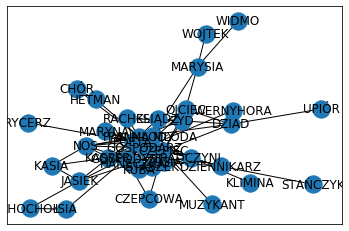

In [19]:
nx.draw_networkx(G, with_labels=True)
plt.show()

In [20]:
nx.write_gexf(G, 'data/wesele_network.gexf')

In [21]:
# Calculate centrality measures for the Graph network with NetworkX
centrality_measures = {
    'degree': nx.degree_centrality(G),
    'betweenness': nx.betweenness_centrality(G),
    'closeness': nx.closeness_centrality(G),
    'eigenvector': nx.eigenvector_centrality(G),
}

# Output the array of centrality measure names in JSON format
with open('data/centrality-measures.json', 'w') as f:
    json.dump(list(centrality_measures.keys()), f, indent=2)

# Create the basic structure of a force-directed D3 network
d3_graph = {
    'nodes': [],
    'links': [],
}

# Add each node in the network to the D3 network
for node in G.nodes():
    d3_graph_node = {
        'id': str(node),
        'centrality': {},
    }
    for centrality_measure in centrality_measures:
        d3_graph_node['centrality'][centrality_measure] = centrality_measures[centrality_measure][node]
    d3_graph['nodes'].append(d3_graph_node)

# Add each edge in the kkg network to the D3 network
for (source, target) in G.edges():
    d3_graph_edge = {
        'source': str(source),
        'target': str(target)
    }
    d3_graph['links'].append(d3_graph_edge)

# Output the kkg network graph in JSON format
with open('data/network_graph.json', 'w') as f:
    json.dump(d3_graph, f, indent=2)

# Zapisanie plików korpusu
Poniższy fragment eksportuje każdy dialog do pliku `.txt` z zachowanie metadanych w nazwie pliku. Np.: `a01s01d01_czepiec.txt` to plik zawierający zwrotkę, pochodzącą z aktu 1, sceny 1, dialog 1, wypowiedzianą przez postać CZEPIEC. Tak oznakowane pliki eksportowane są do jednego folderu o nazwie `corpus`.

In [22]:
full_text

{'Autor': 'Stanisław Wyspiański',
 'Tytuł': 'Wesele',
 'Podtytuł': 'Dramat w trzech aktach',
 'Dekoracja': '\nNoc listopadowa; w chacie, w świetlicy. Izba wybielona siwo, prawie błękitna, jednym szarawym tonem półbłękitu obejmująca i sprzęty, i ludzi, którzy się przez nią przesuną.\nPrzez drzwi otwarte z boku, ku sieni, słychać huczne weselisko, buczące basy, piskanie skrzypiec, niesforny klarnet, hukania chłopów i bab i przygłuszający wszystką nutę jeden melodyjny szum i rumot tupotających tancerzy, co się tam kręcą w zbitej masie w takt jakiejś ginącej we wrzawie piosenki….\nI cała uwaga osób, które przez tę izbę-scenę przejdą, zwrócona jest tam, ciągle tam; zasłuchani, zapatrzeni ustawicznie w ten tan, na polską nutę… wirujący dookoła, w półświetle kuchennej lampy, taniec kolorów, krasychwstążek, pawich piór, kierezyj, barwnych kaftanówi kabatów, nasza dzisiejsza wiejska Polska.\nA na ścianie głębnej: drzwi do alkierzyka, gdzie łóżko gospodarstwa i kołyska, i pośpione na łóżkach dzi

In [35]:
# for act in full_text['Akty']:
#     act_number = act["Akt"]
#     for scene in act['Sceny']:
#         scene_number = scene["Scena"]
#         print(act_number, scene_number)
#         for dialog_index, dialog in enumerate(scene['Dialog']):
#             print(scene_index)
#             file_name = "a" + str(act_index + 1).zfill(2) + "s" + str(scene_index + 1).zfill(2) + "d" + str(dialog_index + 1).zfill(2) + "_" + dialog["Osoba"].lower() + ".txt"
#             print(file_name)

1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 37
1 38
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 37
1 38
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 37
1 38
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19
2 20
2 21
2 22
2 23
2 24
2 25
2 26
2 27
2 28
2 29
2 30
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19
2 20
2 21
2 22
2 23
2 24
2 25
2 26
2 27
2 28
2 29
2 30
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19
2 20
2 21
2 22
2 23
2 24
2 25
2 26
2 27
2 28
2 29
2 30
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 